In [1]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit

In [2]:
import sys
sys.path.append("/g/g92/dskoda/prj/dskrc/python/inits")

from plotting import *
plt.rcParams['figure.dpi'] = 150

In [3]:
NEQUIP_LABELS = {
    '2layer': "2-layer",
    '3layer': "3-layer",
    '4layer': "4-layer",
    '5layer': "5-layer",
    'non_trainable_bessel': 'non_trainable_bessel',
    'rescaling': "rescaling",
    "baseline": "baseline",
    '2layer_yes_rescaling_yes_amsgrad_no_ema': "2-layer, AMSGrad-only", 
    '2layer_yes_rescaling_no_amsgrad_no_ema': '2-layer, baseline',
    '2layer_yes_rescaling_no_amsgrad_yes_ema': "2-layer, EMA-only",
    '5layer_yes_rescaling_yes_amsgrad_no_ema': "5-layer, AMSGrad-only", 
    '5layer_yes_rescaling_no_amsgrad_no_ema': '5-layer, baseline',
    '5layer_yes_rescaling_no_amsgrad_yes_ema': "5-layer, EMA-only",
}

num_params = pd.Series({
    '2-layer': 615363,
    '3-layer': 1100405,
    '4-layer': 1585447,
    '5-layer': 2070489,
    '2-layer, baseline': 615363,
    '2-layer, EMA-only': 615363,
    '2-layer, AMSGrad-only': 615363,
    '5-layer, baseline': 2070489,
    '5-layer, EMA-only': 2070489,
    '5-layer, AMSGrad-only': 2070489,
    'baseline': 615355,
    'non_trainable_bessel': 615363,
    'rescaling': 615363
})

MODELS_BIG = ["baseline", "non_trainable_bessel", "rescaling"]
MODELS_LAYERS = [f"{i}-layer" for i in range(2, 6)]
MODELS_OPT = [f'2-layer, {i}' for i in ["baseline", "EMA-only", "AMSGrad-only"]]
MODELS_OPT_5 = [f'5-layer, {i}' for i in ["baseline", "EMA-only", "AMSGrad-only"]] + ["5-layer"]

## Loading the learning curves first

In [4]:
with open("/usr/workspace/dsk-jv/trained_models/learning_curves_with_2layer_nequip.json", "r") as f:
    lcurv = json.load(f)

In [5]:
N = [5, 25, 125, 250, 500]

lc_results = []
for m in ["NequIP"]:
    subdict = lcurv[m]["3BPA"]
    for params, curves in subdict.items():
        for row, n in zip(curves, N):
            lc_results.append({
                "model": m,
                "params": params,
                "n": n,
                "e": row[0],
                "f": row[1],
            })

ldf = pd.DataFrame(lc_results)

In [6]:
ldf.params.unique()

array(['baseline', 'rescaling', 'non_trainable_bessel',
       '5-layer, baseline', '5-layer, AMSGrad-only', '5-layer, EMA-only',
       '2-layer', '3-layer', '4-layer', '5-layer', '2-layer, baseline',
       '2-layer, AMSGrad-only', '2-layer, EMA-only'], dtype=object)

## Loading the parameters of the models

In [7]:
import yaml

BASE_PATH = "/usr/workspace/dsk-jv/trained_models/nequip"
models = sorted(os.listdir(BASE_PATH))

def tuple_constructor(loader, node):
    value = loader.construct_sequence(node)
    return tuple(value)

def none_constructor(loader, node):
    return ""

yaml.add_constructor('tag:yaml.org,2002:python/object/new:torch.torch_version.TorchVersion', none_constructor)
yaml.add_constructor('tag:yaml.org,2002:python/object/apply:torch._utils._rebuild_tensor_v2', none_constructor)
yaml.add_constructor('tag:yaml.org,2002:python/tuple', tuple_constructor)

In [8]:
configs = {}

for model in models:
    with open(f"{BASE_PATH}/{model}/config.yaml", 'r') as f:
        cfg = yaml.full_load(f)
    
    configs[model] = cfg

configs = pd.DataFrame(configs).rename(columns=NEQUIP_LABELS).T

In [9]:
vals = [
    "BesselBasis_trainable",
    "l_max",
    "invariant_layers",
    "num_basis",
    "num_layers",
    "num_features",
    "optimizer_amsgrad",
    "use_ema",
#     "model_builders"
]

In [10]:
configs[vals]

,BesselBasis_trainable,l_max,invariant_layers,num_basis,num_layers,num_features,optimizer_amsgrad,use_ema
2-layer,False,3,3,8,2,64,True,True
"2-layer, baseline",True,3,3,8,2,64,False,False
"2-layer, EMA-only",True,3,3,8,2,64,False,True
"2-layer, AMSGrad-only",True,3,3,8,2,64,True,False
3-layer,False,3,3,8,3,64,True,True
4-layer,False,3,3,8,4,64,True,True
5-layer,False,3,3,8,5,64,True,True
"5-layer, baseline",False,3,3,8,5,64,False,False
"5-layer, EMA-only",False,3,3,8,5,64,False,True
"5-layer, AMSGrad-only",False,3,3,8,5,64,True,False


## Now loading the LLs

In [11]:
BASE_PATH = "/usr/workspace/dsk-jv/trained_models/nequip"

models = sorted(os.listdir(BASE_PATH))

In [12]:
results = []

x = np.linspace(-0.25, 0.25, 81)
for model in models:
    forces = np.load(os.path.join(BASE_PATH, model, "forces_rays.npy"))
    energy = np.load(os.path.join(BASE_PATH, model, "energy_rays.npy"))
    
    for _x, _f, _e in zip(x, forces, energy):
        results.append({
            "model": model,
            "x": _x,
            "f": _f,
            "e": _e,
        })

df = pd.DataFrame(results)
df["model"] = df["model"].apply(lambda x: NEQUIP_LABELS.get(x, x))

## Finally, loading the explosion times

In [13]:
exp = pd.read_csv("02_data/nequip_explosion.csv", index_col=0)
exp["model"] = exp["model"].apply(lambda x: NEQUIP_LABELS.get(x, x))
exp.to_csv("02_data/nequip_explosion.csv")

mexp = exp.groupby("model")["explosion"].mean()
mexp.name = "explosion_mean"

mdexp = exp.groupby("model")["explosion"].median()
mdexp.name = "explosion_med"

sexp = exp.groupby("model")["explosion"].std()
sexp.name = "explosion_std"

iqexp = exp.groupby("model")["explosion"].agg(stats.iqr)
iqexp.name = "explosion_iqr"

q25exp = exp.groupby("model")["explosion"].agg(lambda x: np.percentile(x, 25))
q25exp.name = "explosion_25th"

all_exp = pd.concat([
    mexp,
    mdexp,
    sexp,
    iqexp,
    q25exp,
], axis=1)

In [14]:
all_exp

,explosion_mean,explosion_med,explosion_std,explosion_iqr,explosion_25th
model,,,,,
2-layer,1955.533333,1796.0,588.900479,880.50,1507.75
"2-layer, AMSGrad-only",2239.700000,1948.0,1141.281649,1273.25,1520.25
"2-layer, EMA-only",1507.166667,1337.0,445.055757,375.75,1206.75
"2-layer, baseline",2036.133333,1802.5,757.188891,1024.25,1408.00
3-layer,3639.266667,3663.0,1819.774540,3357.25,1929.75
4-layer,3671.833333,3008.5,1637.713736,3116.50,2351.50
5-layer,4621.833333,5745.0,1634.003632,2479.25,3521.75
"5-layer, AMSGrad-only",3617.466667,3432.0,1647.839081,2409.00,2349.75
"5-layer, EMA-only",2272.266667,2050.0,1032.368884,1321.75,1448.00


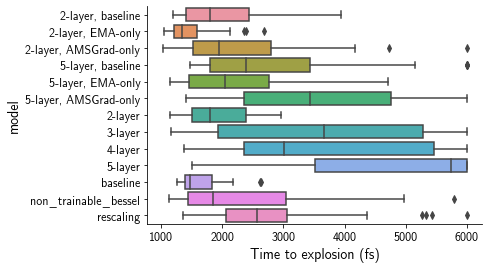

In [15]:
fig, ax = plt.subplots()

sns.boxplot(
    data=exp,
    x="explosion",
    y="model",
    ax=ax,
)

ax.set_xlabel("Time to explosion (fs)")
plt.show()

## Analyzing the loss landscapes

### Calculating metrics on the loss landscape

In [16]:
def get_curvature(x, y):
    def parabola(x, a, b, c):
        return a * x**2 + b * x + c

    A = np.vstack([x**2, x, np.ones(len(x))]).T
    b = y

    params, residuals, rank, s = np.linalg.lstsq(A, b, rcond=None)

    a, b, c = params

    curvature = 2 * a / ((1 + b**2)**(3/2))

    return curvature

def get_entropy(x, T=1e-2, k=1.0):
    y = x# - x.min()
    beta = 1 / (k * T)
    Q = np.sum(np.exp(-beta * y))
    return k * np.log(Q)

In [17]:
_sdf = []

T_F = 4e-2
T_E = 4e-3
ALPHA = 0.2
X_THRESHOLD = 0.025

for model, _df in df.groupby("model"):    
    Sf = get_entropy(_df["f"].values, T=T_F)
    Se = get_entropy(_df["e"].values, T=T_E)
    
    _subdf = _df.loc[np.abs(_df.x) < X_THRESHOLD]
    curv_e = get_curvature(_subdf.x, _subdf.e)
    curv_f = get_curvature(_subdf.x, _subdf.f)

    _sdf.append({
        "model": model,
        "Se": Se,
        "Sf": Sf,
        "S": ALPHA * Se + (1 - ALPHA) * Sf,
        "Ce": curv_e,
        "Cf": curv_f,
    })

In [18]:
sdf = pd.DataFrame(_sdf)
sdf = pd.concat([
    sdf.set_index("model"),
    all_exp,
], axis=1)

sdf["num_params"] = num_params

In [19]:
nldf = ldf.loc[
    (ldf.model == "NequIP")
    & (ldf["n"] == 500)
].set_index("params")[["e", "f"]]

In [20]:
trainable = pd.DataFrame([{
    '2-layer': 0,
    '3-layer': 0,
    '4-layer': 0,
    '5-layer': 0,
    '2-layer, AMSGrad-only': 1,
    '2-layer, EMA-only': 1,
    '2-layer, baseline': 1,
    '5-layer, AMSGrad-only': 0,
    '5-layer, EMA-only': 0,
    '5-layer, baseline': 0,
    'baseline': 1,
    'non_trainable_bessel': 0,
    'rescaling': 1,
}], index=["trainable"]).T

data = pd.concat([
    sdf,
    nldf,
    trainable
], axis=1)

In [21]:
all_exp.to_csv("02_data/nequip_explosion_stats.csv")
ldf.drop("model", axis=1).rename(columns={"params": "model"}).to_csv("02_data/nequip_learning.csv")
df.to_csv("02_data/nequip_losslands.csv")
configs.to_csv("02_data/nequip_hyperparams.csv")
data.to_csv("02_data/nequip_entropy.csv")